In [1]:
from importlib import reload
# Tips to me:
# Use Python 3.11.6
# That's in the location /opt/homebrew/bin/python3

# Libraries
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import dataset_creator as dataset
from IPython.display import Audio
from pprint import pprint
import Nets
reload (Nets)

from Nets import complicatedNet, AnotherNet
from torch.nn import functional as F
import models
from dotenv import load_dotenv
import model_trainer


load_dotenv()

True

In [2]:
reload(dataset)
all_set = dataset.AudioDatasetAt("data/clipses", limit=10000, split_duration=2)
trainset, testset, validationset = dataset.split_dataset(all_set, [0.9, 0.05, 0.1])
# testset = dataset.AudioDatasetAt("datasets/clips/test",limit=200)
# trainset = dataset.AudioDatasetAt("datasets/clips/train", limit=10000)
# validationset = dataset.AudioDatasetAt("datasets/clips/validation", limit=500)


In [3]:
reload(dataset)
# Check Loaders
from torch.utils.data import DataLoader
# trainloader = DataLoader(trainset, 32, shuffle=True, collate_fn=dataset.my_collater)
# validationloader = DataLoader(validationset, 8, shuffle=True, collate_fn=dataset.my_collater)
# testloader = DataLoader(testset, 8, shuffle=True, collate_fn=dataset.my_collater)
trainloader = DataLoader(trainset, 16, shuffle=True)
validationloader = DataLoader(validationset, 4, shuffle=True)
testloader = DataLoader(testset, 8, shuffle=True)

In [8]:
wf = all_set.get_random().unsqueeze(0)
inp = wf
print(inp.shape)
Audio(inp[0], rate=32000, autoplay=True)

Getting 9311th item from the 10002 datasets.
torch.Size([1, 1, 64000])


In [5]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In [9]:
# Instantiating a model
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from Nets import AnotherNet

reload(AnotherNet)
reload(models)
from torch.optim import SGD, Adam

encoder = AnotherNet.Encoder(4)
quantizer = AnotherNet.Quantizer()
decoder = AnotherNet.Decoder(4)
my_model = models.allNet(
    encoder=encoder, quantizer=quantizer, decoder=decoder
)
device = 'cpu'
my_model.to(device)
dummydata = torch.rand([1,1,96000]).to(device)
dummydata = inp

dummy_output = my_model(dummydata).detach()

# my_model.compile(backend="aot_eager")


# lossfn.compile(backend="inductor")
# optimizer = SGD(my_model.parameters(), lr=0.01, weight_decay=0.97)
optimizer = Adam(my_model.parameters()) #, lr=0.1, weight_decay=0.97)

print(my_model)
print(dummydata.shape, dummy_output.shape)
Audio(dummy_output[0], rate=32000)

allNet(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ResidualDown(
        (Conv1): ConvolutionalStack(
          (BNorm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(1, 2, kernel_size=(11,), stride=(1,))
          )
        )
        (Conv2): ConvolutionalStack(
          (BNorm1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(3, 2, kernel_size=(11,), stride=(1,), dilation=(3,))
          )
        )
        (Conv3): ConvolutionalStack(
          (BNorm1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(5, 2, kernel_size=(11,), stride=(1,), dilation=(9,))
          )
    

In [23]:
# Checking Forward Propagation
reload(AnotherNet)
lossfn = AnotherNet.LossFunction().to('cpu')

# Upto prediction
x = inp.to(device)
my_model.train()
output = my_model(x)
output_bf = output[0].cpu().squeeze().unsqueeze(0).detach()

# Calculating loss
loss = lossfn(output, x)

print("input", x.shape, "on", x.device)
print("output", output.shape, "on", output.device)
print("Before Training, Model's output is :")
Audio(output_bf, rate=32000)


input torch.Size([1, 1, 64000]) on cpu
output torch.Size([1, 1, 64000]) on cpu
Before Training, Model's output is :


In [24]:
# Checking back propagation
loss.backward()

In [21]:
reload(model_trainer)
statistics = model_trainer.null_stats()

In [14]:
import model_trainer
reload(model_trainer)

old_stats = statistics
statistics = model_trainer.train_and_validate(my_model, lossfn, optimizer, trainloader, validationloader, True, 50)
statistics = model_trainer.concatenate_stats(old_stats, statistics)

# Seeing output of the training
x = inp.to(device)
my_model.eval()
output_af = my_model(    x
    )[0].cpu().squeeze().unsqueeze(0).detach()

print(x.shape)
print(output_af.shape)
print("After Training, Model is :")
Audio(output_af, rate=32000)

Training for 300 batches.

Batch 1:
Training step:
Forward propagating... 
Done. Time taken = 23.159270763397217
Back Propagating... 
Done. Time taken = 3.5030269622802734
Saving statistics: Loss (avg) = 0.05966264754533768

Validation step:
Forward propagating... 
Done. Time taken = 1.647601842880249
Saving statistics: Loss (avg) = 0.020527241751551628


Batch 2:
Training step:
Forward propagating... 
Done. Time taken = 19.408111095428467
Back Propagating... 
Done. Time taken = 3.670276641845703
Saving statistics: Loss (avg) = 0.03136944770812988

Validation step:
Forward propagating... 
Done. Time taken = 2.39254093170166
Saving statistics: Loss (avg) = 0.019194571301341057


Batch 3:
Training step:
Forward propagating... 
Done. Time taken = 15.747642278671265
Back Propagating... 
Done. Time taken = 2.589381694793701
Saving statistics: Loss (avg) = 0.02949499525129795

Validation step:
Forward propagating... 
Done. Time taken = 1.0129179954528809
Saving statistics: Loss (avg) = 0.011

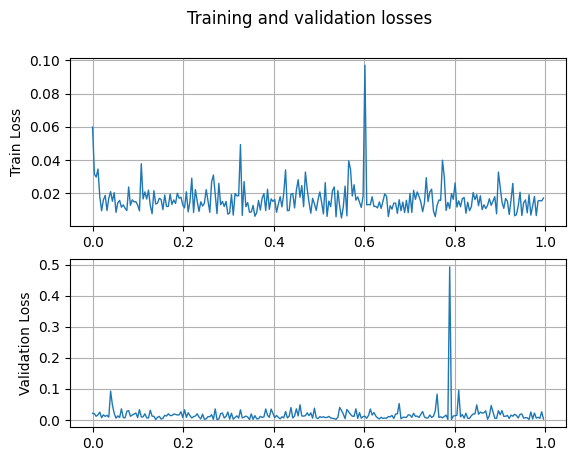

In [15]:
from utilities import plotting
reload(plotting)
plotting.plot_statistics(statistics)

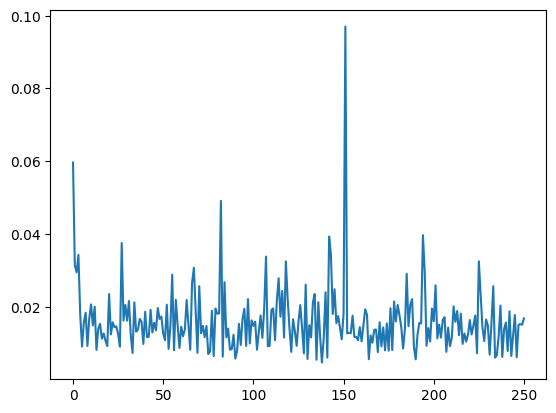

In [16]:
plt.subplot
plt.plot(statistics['TrainLosses'])

In [17]:
x = inp.to(device)
my_model.eval()
output_af = my_model(    x
    )[0].cpu().squeeze().unsqueeze(0).detach()

print(x.shape)
print(output_af.shape)
print("After Training, Model is :")
Audio(output_af, rate=32000)

torch.Size([1, 1, 64000])
torch.Size([1, 64000])
After Training, Model is :


In [18]:
# Save model to disk

reload(model_trainer)
model_trainer.save_model(my_model, "Another-Net", statistics)

Saved model to models/Another-Net/model_state_dict.pth
Saved statistics to models/Another-Net/statistics.pth


In [ ]:
# Load model from disk

reload(model_trainer)
statistics = model_trainer.retrieve_model(my_model, "models/Another-Net")
print(old_stats)

x = inp.to(device)
my_model.eval()
output = my_model(    x
    )[0].cpu().squeeze().unsqueeze(0).detach()

print(x.shape)
print(output.shape)
print("After Training, Model is :")
Audio(output, rate=32000)

In [ ]:
from utilities.plotting import plot_waveform
plot_waveform(x[0], 32000)
# plot_waveform(output_bf, 32000)
plot_waveform(output_af, 32000)

In [ ]:
spectrogramer1 = torchaudio.transforms.MelSpectrogram(32000)
spectrogramer2 = torchaudio.transforms.MelSpectrogram(32000)

In [ ]:
image1 = spectrogramer1(inp).cpu().detach()
image2 = spectrogramer1(out).cpu().detach()
image1 = F.interpolate(image1, scale_factor=.1, mode='bilinear').squeeze()
image2 = F.interpolate(image2, scale_factor=.1, mode='bilinear').squeeze()
# image1 = F.interpolate(image1, mode='linear', scale_factor=10).squeeze()
image1.shape, image2.shape

In [ ]:
plt.figure(figsize=(20,7))
plt.figure(211)
plt.imshow(image1)
plt.figure(212)
plt.imshow(image2)

In [ ]:
mystat = statistics

In [ ]:
reload(model_trainer)
stat1 = mystat
stat2 = mystat
con_stat = model_trainer.concatenate_stats(stat1, stat2)
plotting.plot_statistics(con_stat)

In [ ]:
pprint(con_stat)